<a href="https://colab.research.google.com/github/bdcs02/stock-prediction/blob/main/R%C3%A9szv%C3%A9nyek_el%C5%91rejelz%C3%A9se_line%C3%A1ris_regresszi%C3%B3val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adatok előkészítése

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

ticker1 = "BTC-USD"
ticker2 = "ETH-USD"

# Start nem kötelező paraméter, átláthatóbb adatmennyiség miatt
df = yf.download(f"{ticker1},{ticker2}",start="2022-01-01")



[*********************100%%**********************]  2 of 2 completed


# Egyszerű lineáris regresszó

Korrelációs együttható: 0.8777
R-négyzet érték: 0.7703
Regresszió egyenes: BTC-USD = 0.6886484072072803 * ETH-USD + 0.31156414796184995


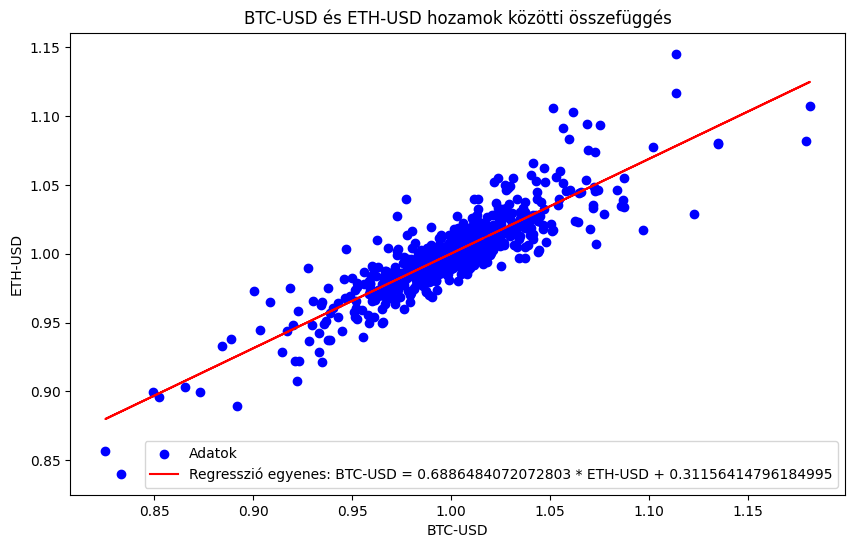

In [ ]:
# Százalékosan meghatározzuk a zárási árfolyamot (ha nem kriptovaluta lenne akkor az Adj Close pontosabb értéked ad mint a Close)

df[ticker1 + '_change'] = df['Adj Close'][ticker1].pct_change() + 1
df[ticker2 + '_change'] = df['Adj Close'][ticker2].pct_change() + 1

# Üres sorokat kidobjuk (ha nem kriptovaluta lenne hanem például amerikai tech részvény akkor a szünnapok miatt üres lenne)
df = df.dropna()

# Előkészítés a modellre

X = df[ticker2+'_change'].values.reshape(-1, 1)
y = df[ticker1+'_change'].values

model = LinearRegression()
model.fit(X, y)


# Korrelációs együttható, regresszió egyenes, R^2 kiszámítása
slope = model.coef_[0]
intercept = model.intercept_

correlation_coefficient = np.corrcoef(X.T, y.T)[0, 1]
r_squared = correlation_coefficient**2

print(f"Korrelációs együttható: {correlation_coefficient:.4f}")
print(f"R-négyzet érték: {r_squared:.4f}")
print(f'Regresszió egyenes: {ticker1} = {slope} * {ticker2} + {intercept}')

# Kirajzolás
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Adatok', color='blue')
plt.plot(X, model.predict(X), color='red', label=f'Regresszió egyenes: {ticker1} = {slope} * {ticker2} + {intercept}')
plt.xlabel(ticker1)
plt.ylabel(ticker2)
plt.legend()
plt.title(f'{ticker1} és {ticker2} hozamok közötti összefüggés')
plt.show()



# Eredeti változás és az előrejelzett
*százalékos formátum*

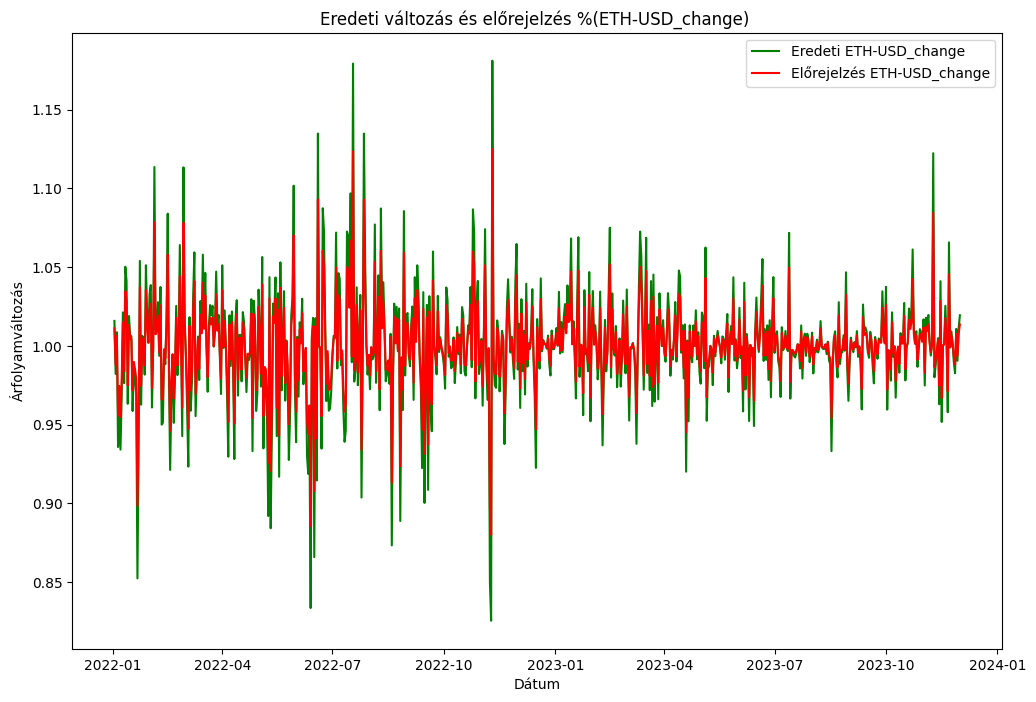

In [ ]:

df['predict_LR'] = model.predict(X)


plt.figure(figsize=(12, 8))
plt.plot(df.index, df[ticker2+'_change'], label=f'Eredeti {ticker2}_change', color='green')

plt.plot(df.index, df['predict_LR'], label=f'Előrejelzés {ticker2}_change', color='red')

plt.xlabel('Dátum')
plt.ylabel('Árfolyamváltozás')
plt.legend()
plt.title(f'Eredeti változás és előrejelzés %({ticker2}_change) ')
plt.show()



# PÁROS KERESKEDÉS (Pairs Trading)
  *HA AZ ELSŐ RÉSZVÉNY NŐ AKKOR A MÁSODIKBÓL IS VESZÜNK HA CSÖKKEN AKKOR ELADUNK*

  Úgy gondoljuk hogy az első és második részvény között kapcsolat van ezért választjuk ezt a stratégiát.
  Példa lehet az
  AAPL és GOOGL
  BTC-ETH

Vásárlás: 333 db 
Eladás: 365 db


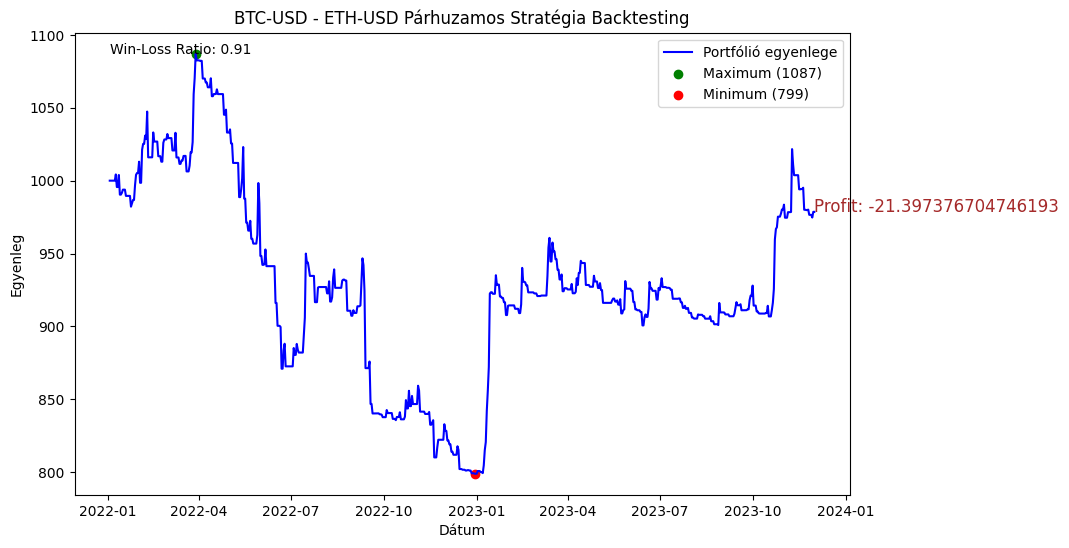

In [ ]:



ticker1_prices = df['Adj Close'][ticker1]
ticker2_prices = df['Adj Close'][ticker2]

# Stratégia létrehozása és backtesting
ticker2_position = 0
start_balance = 1000
initial_balance = start_balance # Kezdeti egyenleg

buy_pos_count = 0
sell_pos_count = 0

balances = []  # Itt tároljuk az egyenlegeket

for i in range(1, len(df)):
    ticker1_return = (ticker1_prices[i] - ticker1_prices[i - 1]) / ticker1_prices[i - 1]   # Ticker1 napi hozam
    ticker2_return = (ticker2_prices[i] - ticker2_prices[i - 1]) / ticker2_prices[i - 1]   # Ticker2 napi hozam

    if ticker1_return > 0:
        # Ticker1 növekedés esetén veszünk Ticker2-t
        ticker2_position += initial_balance * 0.2 / ticker2_prices[i]  # 20% -ot veszünk Ticker2-ből
        initial_balance -= initial_balance * 0.2
        buy_pos_count = buy_pos_count + 1
    else:
        # Ticker1 csökkenés esetén eladunk Ticker2-t
        initial_balance += ticker2_position * ticker2_prices[i]  # Az összes Ticker2 eladása
        ticker2_position = 0
        sell_pos_count = sell_pos_count + 1

    balance = initial_balance + ticker2_position * ticker2_prices[i]
    balances.append(balance)

# Win - Loss arány
win_loss_rate = buy_pos_count / sell_pos_count


# Eredmények ábrázolása
profit = balances[-1] - start_balance
print(f'Vásárlás: {buy_pos_count} db \nEladás: {sell_pos_count} db')
plt.figure(figsize=(10, 6))
plt.plot(df.index[1:], balances, label='Portfólió egyenlege', color='blue')
plt.scatter(df.index[balances.index(max(balances)) + 1], (max(balances)), color='green', label=f'Maximum ({round(max(balances))})')
plt.scatter(df.index[balances.index(min(balances)) + 1], (min(balances)), color='red', label=f'Minimum ({round(min(balances))})')
plt.text(df.index[-1], balances[-1], f'Profit: {profit}', fontsize=12, color='brown')
plt.text(df.index[1], max(balances), f'Win-Loss Ratio: {win_loss_rate:.2f}', fontsize=10, color='black')
plt.xlabel('Dátum')
plt.ylabel('Egyenleg')
plt.legend()
plt.title(f'{ticker1} - {ticker2} Párhuzamos Stratégia Backtesting')
plt.show()

# Árfolyam becslése


<ipython-input-5-5e853eaa57d2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predict_LR'] = model.predict(X)


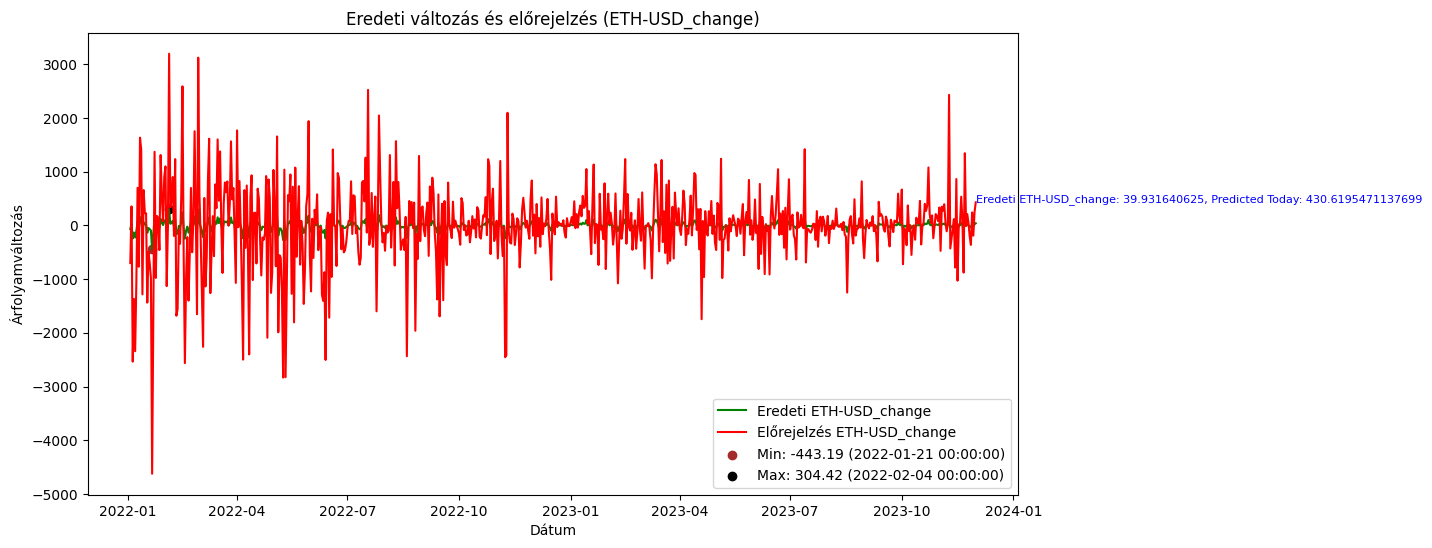

In [ ]:
# Nem a százalékos zárást hanem érték szerintit nézek

df[ticker1 + '_change'] = df['Adj Close'][ticker1].diff()
df[ticker2 + '_change'] = df['Adj Close'][ticker2].diff()

df = df.dropna()

# Modell illesztés
X = df[ticker2+'_change'].values.reshape(-1, 1)
y = df[ticker1+'_change'].values

model = LinearRegression()
model.fit(X, y)
df['predict_LR'] = model.predict(X)


# Rajzolás, egyéb infó
min_value = df[ticker2+'_change'].min()
max_value = df[ticker2+'_change'].max()

min_date = df[ticker2+'_change'].idxmin()
max_date = df[ticker2+'_change'].idxmax()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[ticker2+'_change'], label=f'Eredeti {ticker2}_change', color='green')
plt.plot(df.index, df['predict_LR'], label=f'Előrejelzés {ticker2}_change', color='red')


plt.scatter(min_date, min_value, marker='o', color='brown', label=f'Min: {min_value:.2f} ({min_date})')
plt.scatter(max_date, max_value, marker='o', color='black', label=f'Max: {max_value:.2f} ({max_date})')

plt.xlabel('Dátum')
plt.ylabel('Árfolyamváltozás')
plt.legend()
plt.title(f'Eredeti változás és előrejelzés ({ticker2}_change)')

x_coord = df.index[-1]
y_coord = df['predict_LR'].tail(1).values[0]
predicted_today = df['predict_LR'].tail(1).values[0]

df_changed_for_label = df[ticker2+'_change'].tail(1).values[0]
label = f'Eredeti {ticker2}_change: {df_changed_for_label}, Predicted Today: {predicted_today}'
plt.text(x_coord, y_coord, label, fontsize=8, color='blue')

plt.show()




# Mozgóátlag


Text(0.5, 1.0, 'ETH-USD - Eredeti és 15 Napos Mozgóátlag')

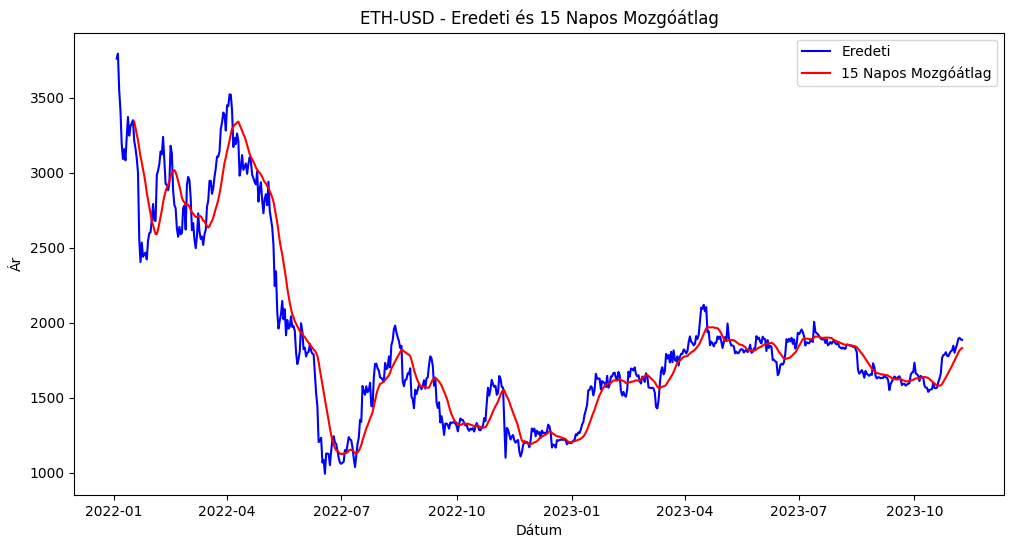

In [ ]:
from matplotlib import ticker

df[ticker2 + '_15MA'] = df['Adj Close'][ticker2].rolling(15).mean()


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'][ticker2], label='Eredeti', color='blue')
plt.plot(df.index, df[ticker2 + '_15MA'], label='15 Napos Mozgóátlag', color='red')
plt.xlabel('Dátum')
plt.ylabel('Ár')
plt.legend()
plt.title(f'{ticker2} - Eredeti és 15 Napos Mozgóátlag')





